In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
import seaborn as sns
import pandas as pd
import sys
from tqdm import tqdm
sys.path.append('../Deep_Learning/')
from nn_optimization_methods import SGD
from layers.Dense import Dense
from layers.Input import Input
from layers.Softmax import Softmax
sys.path.append('../tools/')
import tools

%matplotlib inline

# DeepNeuralNetwork 

## Regression

### approximate sin function from random values.

In [2]:
x = np.linspace(-1, 1, 1000)

In [3]:
y = np.sin(x)**2

In [4]:
df = pd.DataFrame({'x':x,'y':y})

In [5]:
class DNN():
    """
    Deep Neural Network Template for regression and classification tasks
    Parameters:
        X: numpy array() data matrix
        y: numpy array() response variables, must be numeric
        output: numpy array() outputs
        outlayer: output layer
        head: input layer
        loss: loss function str
    
    Use like sequential model from Keras:
        Ex: add a dense layer with 200 neurons and a sigmoid activation function:
                dnn.add("dense","sigmoid",200)
    """
    def __init__(self,X,y):
            
        self.X = X
        self.y = y
        self.output = 0
        self.outlayer = Input(self.X)
        self.head = self.outlayer
        self.loss = "MSE"
    
    def add(self,layertype,neurons,activation="sigmoid"):
        
        if layertype == "dense":
                layer = Dense(self.outlayer,neurons,activation)
                self.outlayer.setNext(layer)
                self.outlayer = layer
        elif layertype == "softmax":
            layer = Softmax(self.outlayer,neurons)
            self.outlayer.setNext(layer)
            self.outlayer = layer
            
    def forward(self,inputs=None):
        
        if np.all(inputs != None):
            
            self.head.update(inputs)
            
        layer = self.head
        
        while np.all(layer.next != None):
            
            layer.forward()
            layer = layer.getNext()
        
        layer.forward()
        return layer.output
        
    def backward_pass(self,predictions,y):
        
        cache = 0
        gradients = []
                    
        layer = self.outlayer
        cache = np.array((predictions - y))
        w_derivative = layer.getPrev().dot(cache*(layer.deriv),True)
        b_derivative = cache*(layer.deriv)
        gradients.append([w_derivative,b_derivative])
        layer = layer.getPrev()
        while np.all(layer.getPrev() != None):
            cache = (cache.dot(layer.getNext().getWeights()[0].T))*layer.deriv
            w_derivative = layer.getPrev().dot(cache,True)
            b_derivative = cache
            gradients.append([w_derivative,b_derivative])
            layer = layer.getPrev()

        return gradients[::-1]
        
    def train(self,X,y,optimizer=SGD,lr=0.0001,epochs=100,batch_size=1,loss="mse"):
        self.loss = loss
        optimizer(self,X,y,learning_rate=lr,epochs=epochs,batch_size=batch_size,loss=loss)
        
    def predict(self,X):
        if self.loss == "cross_entropy":
            return np.argmax(self.forward(X),axis=1)
        return self.forward(X)
        
    def __str__(self):
        
        string = "----------------------------- Model -----------------------------" + '\n'
        layer = self.head
        
        while np.all(layer != None):
            string += layer.__str__()
            layer = layer.getNext()
            
        return string

In [6]:
x = x.reshape(x.shape[0],1)
dnn = DNN(x,y)
dnn.add("dense",24,"sigmoid")
dnn.add("dense",48,"sigmoid")
dnn.add("dense",16,"sigmoid")
dnn.add("dense",1,"linear")
print(dnn)

----------------------------- Model -----------------------------
Input: shape: (None, 1)
-----------------------------------------------------------------
Dense: activation: sigmoid, weight shape: (1, 24), output shape: (None, 24), parameters: 24
-----------------------------------------------------------------
Dense: activation: sigmoid, weight shape: (24, 48), output shape: (None, 48), parameters: 1152
-----------------------------------------------------------------
Dense: activation: sigmoid, weight shape: (48, 16), output shape: (None, 16), parameters: 768
-----------------------------------------------------------------
Dense: activation: linear, weight shape: (16, 1), output shape: (None, 1), parameters: 16
-----------------------------------------------------------------



In [7]:
dnn.train(x,y,lr=0.001,epochs=1000)

MSE 99.5158454361394: 100%|██████████| 1000/1000 [12:23<00:00,  1.34it/s] 


In [8]:
predictions = dnn.predict(x)

In [9]:
predictions = predictions.reshape(predictions.shape[0],)

In [10]:
newd = pd.DataFrame({'x':df["x"],'y':predictions})

In [11]:
df["y"][:20]

0     0.708073
1     0.706251
2     0.704426
3     0.702597
4     0.700765
5     0.698930
6     0.697092
7     0.695250
8     0.693406
9     0.691558
10    0.689707
11    0.687854
12    0.685997
13    0.684137
14    0.682274
15    0.680408
16    0.678540
17    0.676668
18    0.674794
19    0.672917
Name: y, dtype: float64

In [12]:
newd["y"][:20]

0     0.710144
1     0.708197
2     0.706249
3     0.704300
4     0.702349
5     0.700398
6     0.698445
7     0.696492
8     0.694537
9     0.692581
10    0.690624
11    0.688666
12    0.686707
13    0.684747
14    0.682786
15    0.680824
16    0.678861
17    0.676897
18    0.674932
19    0.672966
Name: y, dtype: float64

Predicted after 1000 epochs

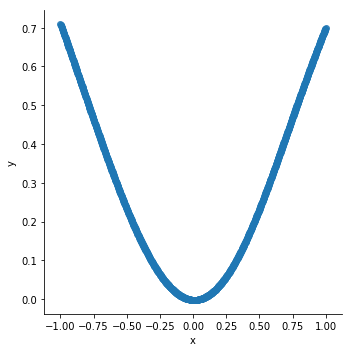

In [13]:
sns.lmplot(x='x', y='y',data=newd,
           fit_reg=False, # No regression line
          )  

Original sin wave

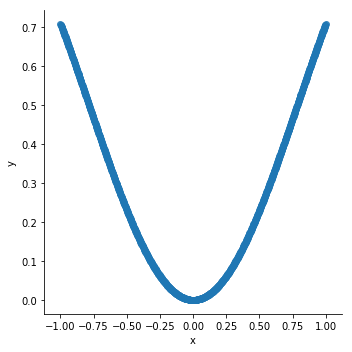

In [14]:
sns.lmplot(x='x', y='y',data=df,
           fit_reg=False, # No regression line
          )   

## Classification

In [15]:
iris = datasets.load_iris()
X = iris.data
y = iris.target
indices = np.arange(y.shape[0])
np.random.shuffle(indices)

In [16]:
X = X[indices]
y = y[indices]
X_train, X_test, y_train, y_test = tools.cross_val_split_set(X,0.1,y)
y_train = np.array(pd.get_dummies(y_train))

In [17]:
dnn = DNN(X_train,y_train)
dnn.add("dense",24,"sigmoid")
dnn.add("dense",48,"sigmoid")
dnn.add("dense",16,"sigmoid")
dnn.add("softmax",3)
print(dnn)

----------------------------- Model -----------------------------
Input: shape: (None, 4)
-----------------------------------------------------------------
Dense: activation: sigmoid, weight shape: (4, 24), output shape: (None, 24), parameters: 96
-----------------------------------------------------------------
Dense: activation: sigmoid, weight shape: (24, 48), output shape: (None, 48), parameters: 1152
-----------------------------------------------------------------
Dense: activation: sigmoid, weight shape: (48, 16), output shape: (None, 16), parameters: 768
-----------------------------------------------------------------
Softmax: activation: softmax, weight shape: (16, 3), output shape: (None, 3), parameters: 48
-----------------------------------------------------------------



In [18]:
dnn.train(X_train,y_train,lr=0.001,epochs=1000,loss="cross_entropy")

Cross Entropy 0.17734656291408363: 100%|██████████| 1000/1000 [02:53<00:00,  5.75it/s]


#### Train Acc

In [19]:
tools.calc_accuracy(dnn.predict(X_train),y_train)

0.9777777777777777

#### Test Acc

In [20]:
tools.calc_accuracy(dnn.predict(X_test),y_test)

1.0